In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sympy as sp

# IMPORTANDO DADOS

In [2]:
df = pd.read_csv('DataBase.csv')
df

,duration,distance,place,type
0,14:39:12,1036.23,SÃO PAULO,VUC
1,13:40:21,887.25,SÃO PAULO,TOCO
2,13:11:51,854.96,SÃO PAULO,TOCO
3,14:06:40,842.50,SÃO PAULO,TOCO
4,13:53:13,839.72,SÃO PAULO,TOCO
...,...,...,...,...
1824,00:00:05,0.00,DUQUE DE CAXIAS,VUC
1825,00:00:05,0.00,DUQUE DE CAXIAS,VUC
1826,00:00:08,0.00,DUQUE DE CAXIAS,VUC
1827,00:00:05,0.00,DUQUE DE CAXIAS,VUC


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1829 entries, 0 to 1828
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   duration  1829 non-null   object 
 1   distance  1829 non-null   float64
 2   place     1829 non-null   object 
 3   type      1829 non-null   object 
dtypes: float64(1), object(3)
memory usage: 57.3+ KB


# TRATAMENTO DOS DADOS
Antes de treinar o modelo é de extrema importância tratar os dados para garantir que a planilha de features (variáveis) esteja em um formato simples, otimizado e sem erros ou valores nulos para maior precisão no modelo de previsão

In [4]:
def removeNullRows(df):
    afected = (df.isna().any(axis=1)).sum()
    print(f'{afected} linhas NaN removidas')
    return df.dropna()


df = removeNullRows(df)

0 linhas NaN removidas


### DADOS NUMÉRICOS
Passando as colunas numéricas para os deus devidos tipos, as vezes o pandas interpreta o número como um objeto ou string

In [5]:
df['distance'] = pd.to_numeric(df.distance, errors='coerce')
df.head()

,duration,distance,place,type
0,14:39:12,1036.23,SÃO PAULO,VUC
1,13:40:21,887.25,SÃO PAULO,TOCO
2,13:11:51,854.96,SÃO PAULO,TOCO
3,14:06:40,842.50,SÃO PAULO,TOCO
4,13:53:13,839.72,SÃO PAULO,TOCO


- Passando a coluna de duração para objeto timedelta do pandas, para realmente podermos trabalhar com os dados no formato de horas e passando essa mesma coluna de duração para segundos, pois será melhor analisar assim, tendo a duração total em somenta 1 unidade

In [6]:
df['duration'] = pd.to_timedelta(df.duration, errors='coerce').dt.total_seconds()
df.head()

,duration,distance,place,type
0,52752.0,1036.23,SÃO PAULO,VUC
1,49221.0,887.25,SÃO PAULO,TOCO
2,47511.0,854.96,SÃO PAULO,TOCO
3,50800.0,842.50,SÃO PAULO,TOCO
4,49993.0,839.72,SÃO PAULO,TOCO


### DADOS CATEGÓRICOS

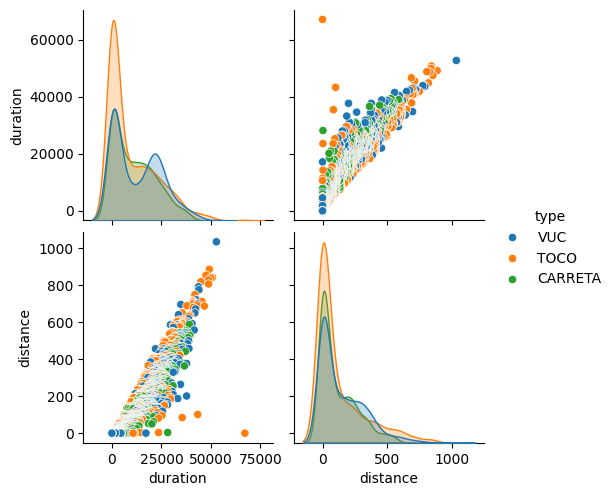

In [7]:
sns.pairplot(df, hue='type')
plt.show()

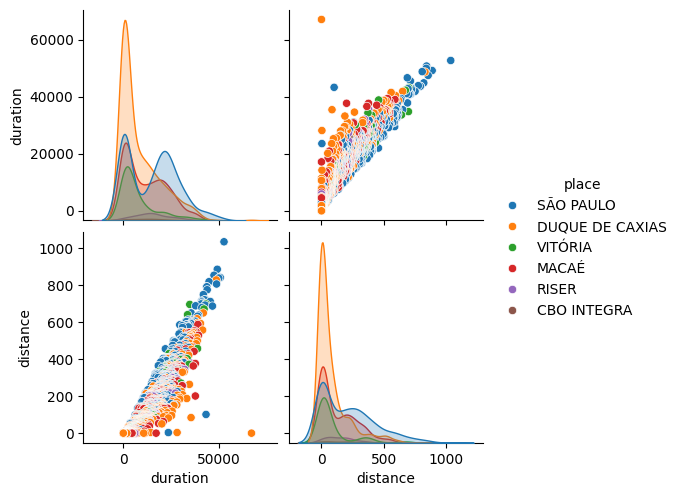

In [8]:
sns.pairplot(df, hue='place')
plt.show()

In [9]:
df['place'] = df.place.str.strip().str.lower().str.replace(' ', '_')
df['type']  = df.type.str.strip().str.lower().str.replace(' ', '_')
df.head()

,duration,distance,place,type
0,52752.0,1036.23,são_paulo,vuc
1,49221.0,887.25,são_paulo,toco
2,47511.0,854.96,são_paulo,toco
3,50800.0,842.50,são_paulo,toco
4,49993.0,839.72,são_paulo,toco


In [10]:
df = pd.get_dummies(df, columns=['place', 'type'])
df.head()

,duration,distance,place_cbo_integra,place_duque_de_caxias,place_macaé,place_riser,place_são_paulo,place_vitória,type_carreta,type_toco,type_vuc
0,52752.0,1036.23,False,False,False,False,True,False,False,False,True
1,49221.0,887.25,False,False,False,False,True,False,False,True,False
2,47511.0,854.96,False,False,False,False,True,False,False,True,False
3,50800.0,842.50,False,False,False,False,True,False,False,True,False
4,49993.0,839.72,False,False,False,False,True,False,False,True,False


In [11]:
df = removeNullRows(df)

5 linhas NaN removidas


# MODELO

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics

In [13]:
xData = df.drop(columns=['distance'])
yData = df.distance
xData.head(5)

,duration,place_cbo_integra,place_duque_de_caxias,place_macaé,place_riser,place_são_paulo,place_vitória,type_carreta,type_toco,type_vuc
0,52752.0,False,False,False,False,True,False,False,False,True
1,49221.0,False,False,False,False,True,False,False,True,False
2,47511.0,False,False,False,False,True,False,False,True,False
3,50800.0,False,False,False,False,True,False,False,True,False
4,49993.0,False,False,False,False,True,False,False,True,False


In [14]:
def plotModel(yTeste, yModel, score=None, tData=None):
    plt.figure(figsize=(10, 5))
    
    if tData is None:
        tData = range(yTeste.shape[0])
    
    if score is not None:
        plt.title(f'Precisão do Modelo: {score*100:.2f}%')

    plt.scatter(tData, yTeste, label='test', s=15, color='blue')
    plt.scatter(tData, yModel, color='orange', label='predicted', s=15)
    plt.xlabel('Referência'), plt.ylabel('Valores')
    plt.legend(), plt.grid()
    plt.show()

### REGRESSÃO LINEAR

In [15]:
from sklearn.linear_model import LinearRegression

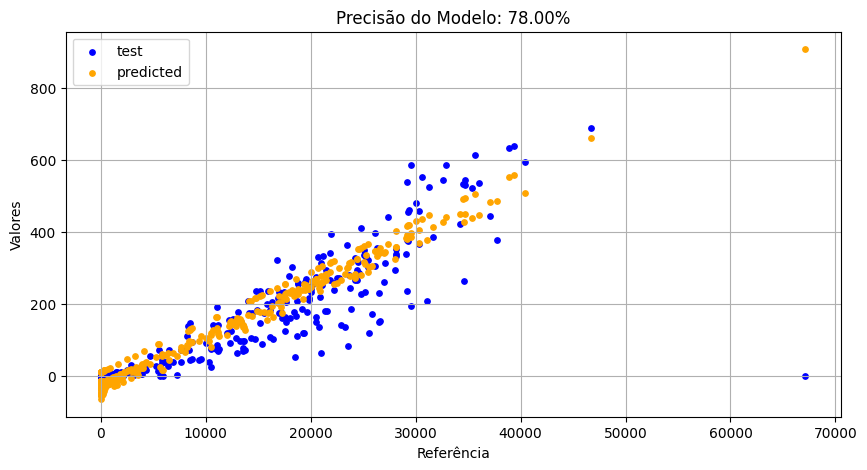

In [16]:
def linearRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score  = metrics.r2_score(yTeste, yModel)
    plotModel(yTeste, yModel, score, xTeste.duration)
    return model


linearModel = linearRegression(xData, yData)

### REGRESSÃO POLINOMIAL

In [17]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

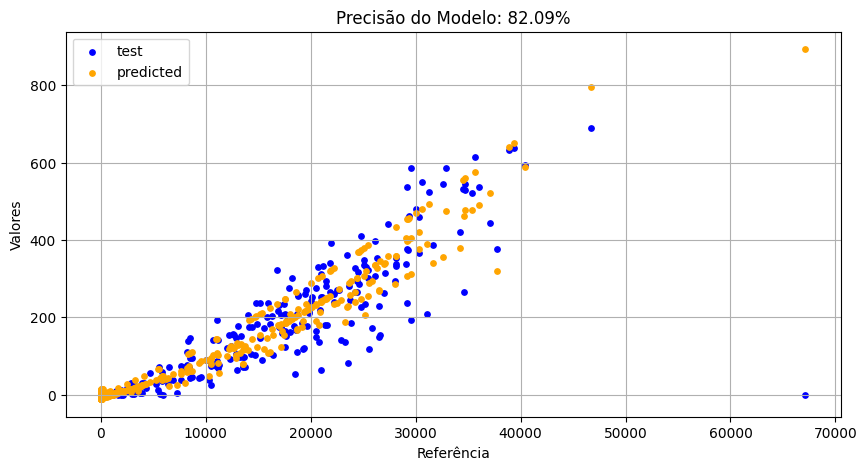

In [18]:
def polinomialRegression(xData, yData, degree=2):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2, random_state=42)
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score  = metrics.r2_score(yTeste, yModel)
    plotModel(yTeste, yModel, score, xTeste.duration)
    return model


polinomialModel = polinomialRegression(xData, yData, degree=3)

### ÁRVORE DE DECISÃO

In [19]:
from sklearn.tree import DecisionTreeRegressor

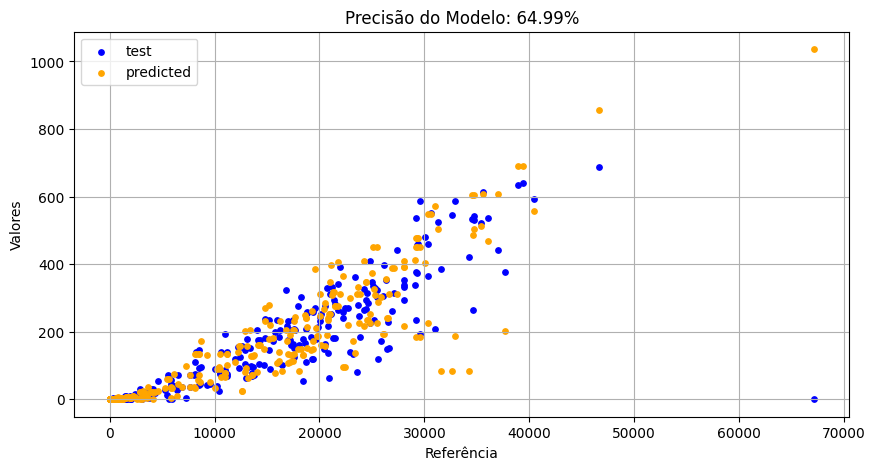

In [20]:
def decisionTreeRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2, random_state=42)
    model = DecisionTreeRegressor()
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score  = metrics.r2_score(yTeste, yModel)
    plotModel(yTeste, yModel, score, xTeste.duration)
    return model


decisionModel = decisionTreeRegression(xData, yData)

### RANDOM FOREST

In [21]:
from sklearn.ensemble import RandomForestRegressor

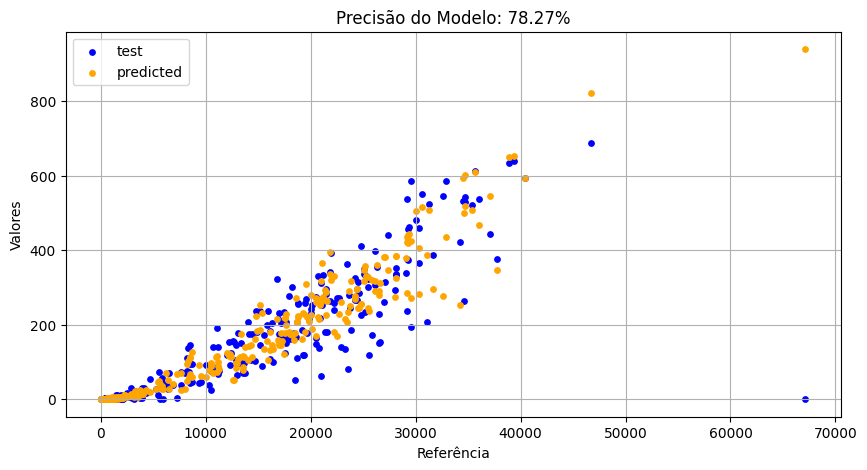

In [22]:
def randomForestRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2, random_state=42)
    model = RandomForestRegressor()
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score  = metrics.r2_score(yTeste, yModel)
    plotModel(yTeste, yModel, score, xTeste.duration)
    return model


forestModel = randomForestRegression(xData, yData)

### SUPORTE VETORIAL PARA REGRESSÃO (SVR)

In [23]:
from sklearn.svm import SVR

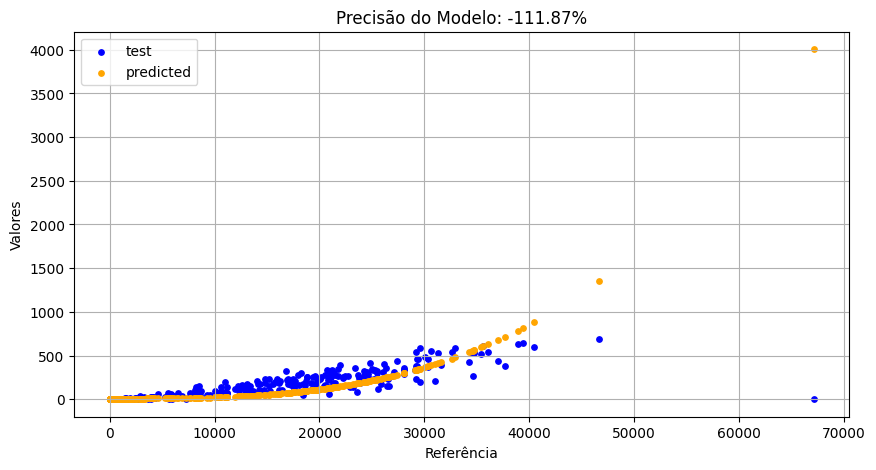

In [24]:
def supportVectorRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2, random_state=42)
    model = SVR(kernel='poly')  # kernel pode ser 'linear', 'poly', ou 'rbf'
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score  = metrics.r2_score(yTeste, yModel)
    plotModel(yTeste, yModel, score, xTeste.duration)
    return model


vectorModel = supportVectorRegression(xData, yData)

### RIDGE REGRESSOR

In [25]:
from sklearn.linear_model import Ridge

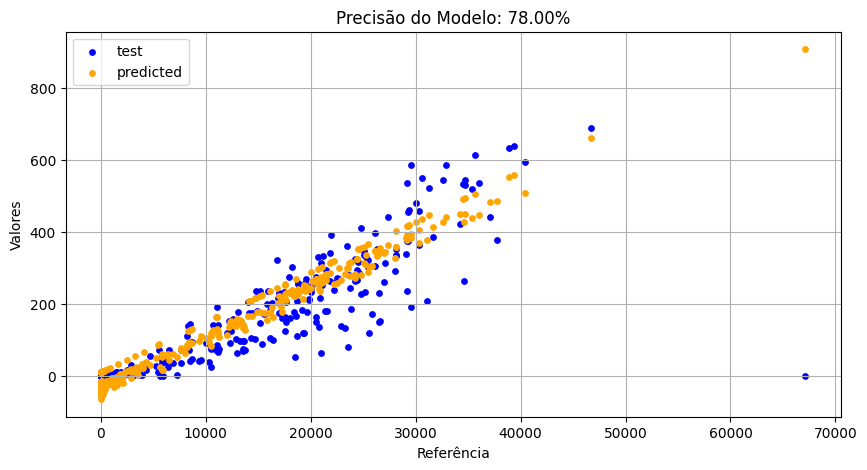

In [26]:
def ridgeRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2, random_state=42)
    model = Ridge(alpha=1.0)  # Ajuste o parâmetro alpha para regularização
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score  = metrics.r2_score(yTeste, yModel)
    plotModel(yTeste, yModel, score, xTeste.duration)
    return model


ridgeModel = ridgeRegression(xData, yData)

### GRADIENT BOOSTER

In [27]:
from sklearn.ensemble import GradientBoostingRegressor

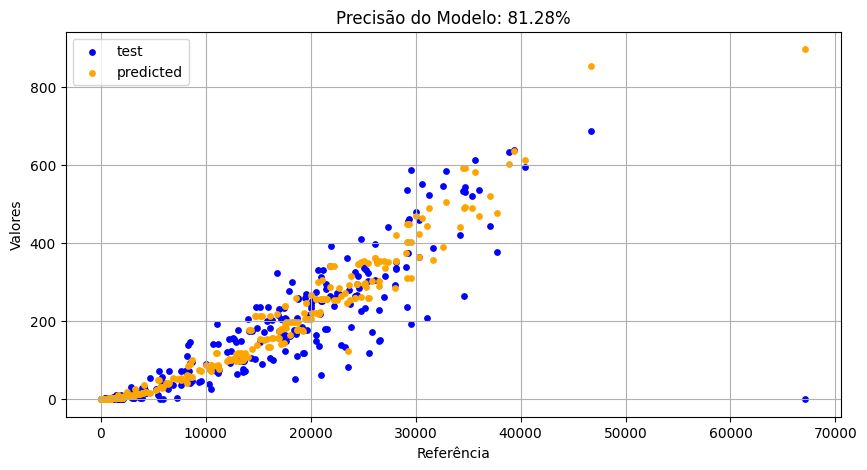

In [28]:
def gradientBoostingRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2, random_state=42)
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score  = metrics.r2_score(yTeste, yModel)
    plotModel(yTeste, yModel, score, xTeste.duration)
    return model


gradientModel = gradientBoostingRegression(xData, yData)

### K-NEAREST NEIGHBORS

In [29]:
from sklearn.neighbors import KNeighborsRegressor

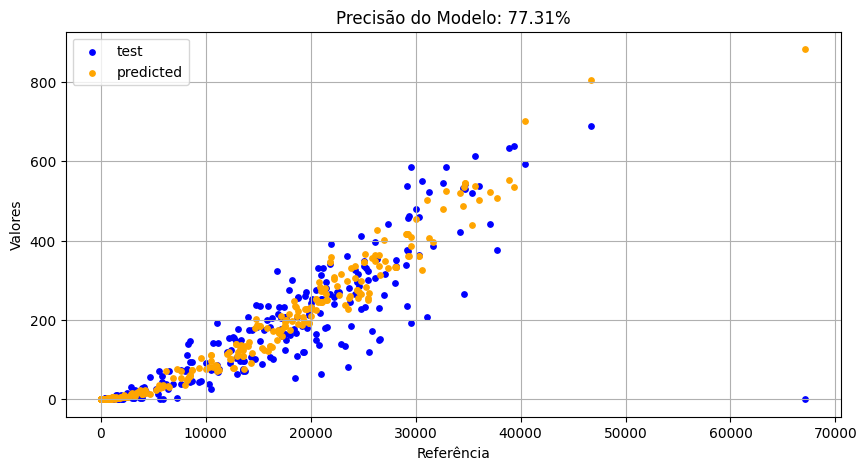

In [30]:
def knnRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2, random_state=42)
    model = KNeighborsRegressor(n_neighbors=5)  # Ajuste n_neighbors conforme necessário
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score  = metrics.r2_score(yTeste, yModel)
    plotModel(yTeste, yModel, score, xTeste.duration)
    return model


knnModel = knnRegression(xData, yData)

### ELASTIC NET

In [31]:
from sklearn.linear_model import ElasticNet

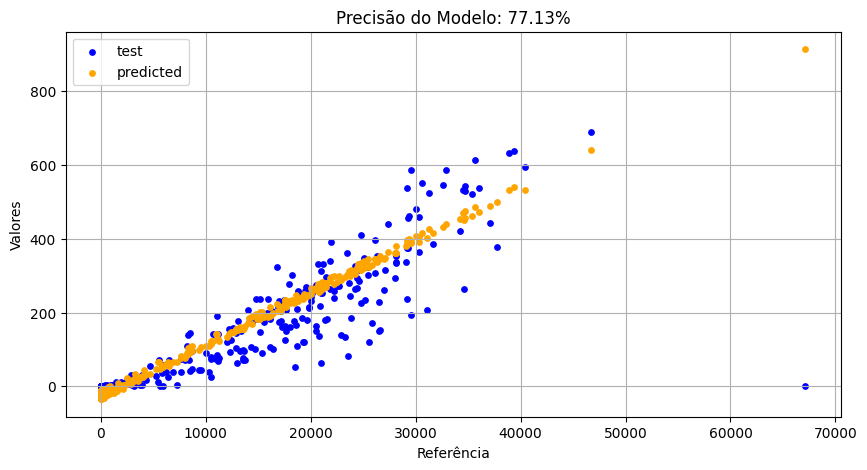

In [32]:
def elasticNetRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2, random_state=42)
    model = ElasticNet(alpha=0.999, l1_ratio=0.5)  # Ajuste alpha e l1_ratio
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score  = metrics.r2_score(yTeste, yModel)
    plotModel(yTeste, yModel, score, xTeste.duration)
    return model


elasticModel = elasticNetRegression(xData, yData)

### XGBOOST REGRESSOR

In [33]:
from xgboost import XGBRegressor

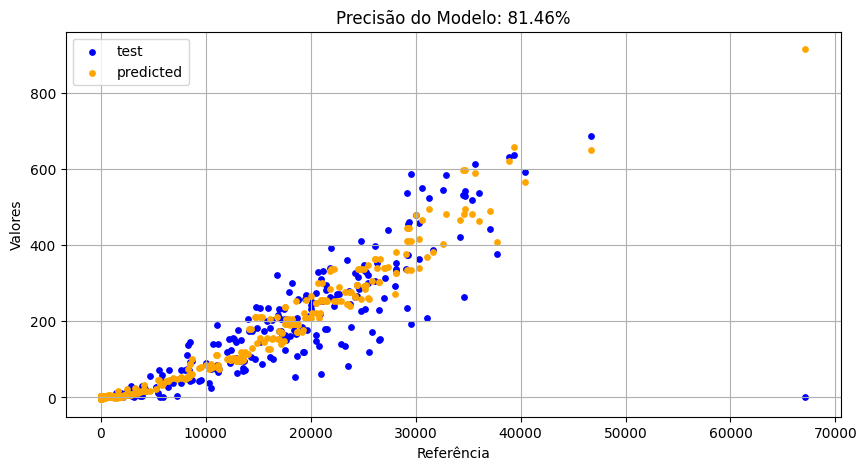

In [34]:
def xgboostRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2, random_state=42)
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score  = metrics.r2_score(yTeste, yModel)
    plotModel(yTeste, yModel, score, xTeste.duration)
    return model


xgboostModel = xgboostRegression(xData, yData)

### LASSO REGRESSION

In [35]:
from sklearn.linear_model import Lasso

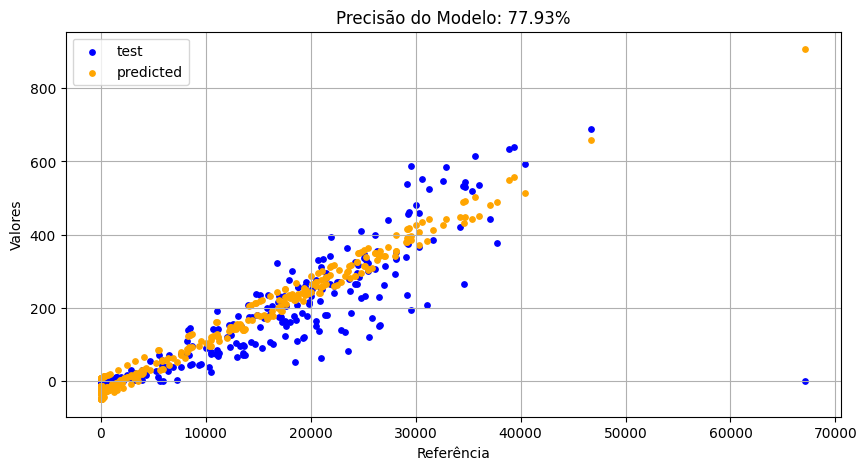

In [36]:
def lassoRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2, random_state=42)
    model = Lasso(alpha=0.3)  # Ajuste alpha conforme necessário
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score  = metrics.r2_score(yTeste, yModel)
    plotModel(yTeste, yModel, score, xTeste.duration)
    return model


lassoModel = lassoRegression(xData, yData)

### CATBOOST REGRESSION

In [37]:
from catboost import CatBoostRegressor

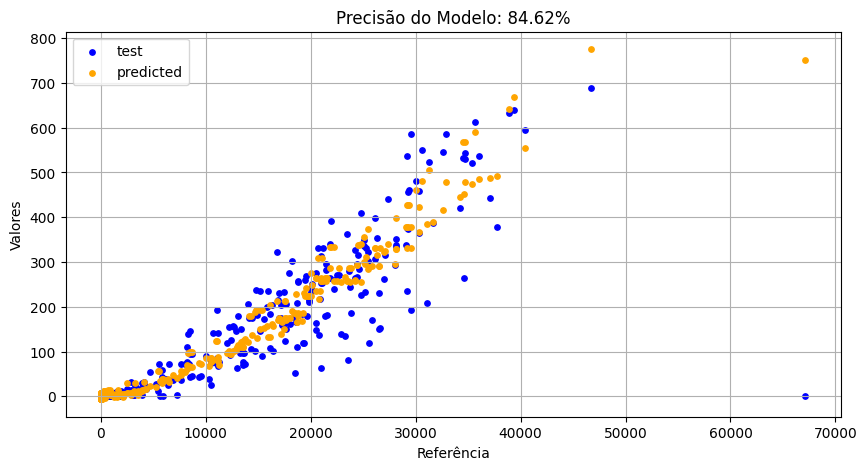

In [38]:
def catboostRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2, random_state=42)
    model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=3, verbose=0)
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score  = metrics.r2_score(yTeste, yModel)
    plotModel(yTeste, yModel, score, xTeste.duration)
    return model


catboostModel = catboostRegression(xData, yData)

### MULTI-LAYER PERCEPTRON (MLP)

In [39]:
from sklearn.neural_network import MLPRegressor

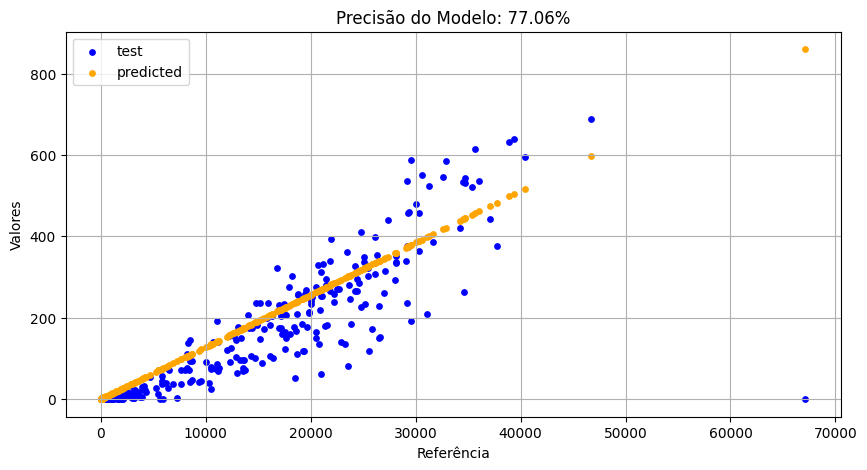

In [40]:
def mlpRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2, random_state=42)
    model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score  = metrics.r2_score(yTeste, yModel)
    plotModel(yTeste, yModel, score, xTeste.duration)
    return model


mlpModel = mlpRegression(xData, yData)

# ESCOLHENDO O MODELO

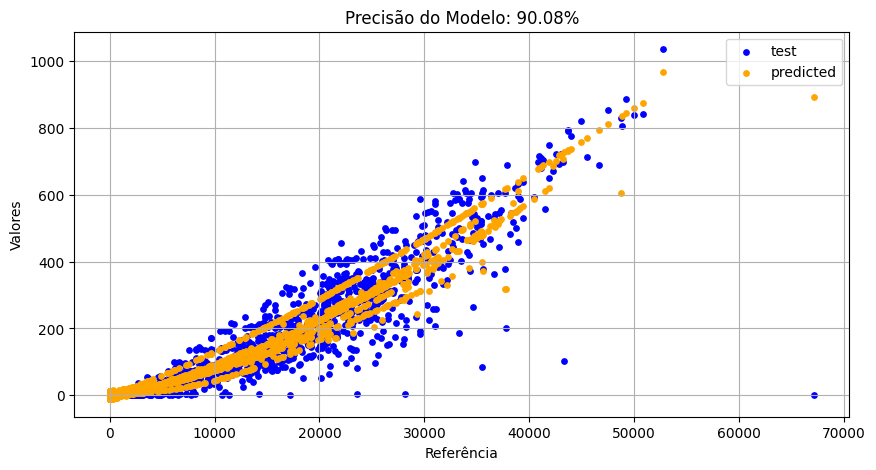

In [41]:
model  = polinomialModel
yModel = model.predict(xData)
score  = metrics.r2_score(yModel, yData)

plotModel(yData, yModel, score, xData.duration)